# Diffusion Models 

## Introduction and Formulation

A Diffusion model are a class of **Generative AI** models that generates high resolution images of varying quality. They work by gradually adding *Gaussian* noise (forward diffusion process) and then learning to remove the noise (reverse diffusion process). They are similar to VAEs (Variational Autoencoders).

<figure>
    <center><img src="img/diffusion.png" width="700" height="200">
    <figcaption>Fig: Forward and Backward Diffusion Process</figcaption></center>
</figure>

## Forward Diffusion

Let $x_0$ the input image. We start by sampling a point $x_0$ from the real distribution $q(x)$ ($x_0 \sim q(x)$) and then adding *Gaussian Noise* with variance $\beta_t$ by 
$$ q(x_t|x_{t-1}) := \mathcal{N}(x_t ; \sqrt{1-\beta_t} x_{t-1} , \beta_t I) \quad ; \quad q(x_{1:T} | x_0) = \prod_{t=1}^{T}q(x_t|x_{t-1})$$ 

Here $\sqrt{1-\beta_t}$ is a scaling factor for values of $\beta_t$ between 0 and 1 that modulates the impact of the previous state in the diffusion process. 

Note that $x_t = \sqrt{(1-\beta_t)}x_{t-1} + \sqrt{\beta_t}\epsilon_{t-1}$ where $\epsilon_{t} \sim \mathcal{N}(0, I)$. If we define $\alpha_t = 1-\beta_t$ and $\overline{\alpha}_t = \prod_{s=0}^{t}\alpha_s$ then 
$$x_t = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon_{t-1} = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{\alpha_t}\sqrt{1-\alpha_{t-1}}\epsilon_{t-2} + \sqrt{1-\alpha_t}\epsilon_{t-1}$$ 
But $ \sqrt{\alpha_t}\sqrt{1-\alpha_{t-1}}\epsilon_{t-2} + \sqrt{1-\alpha_t}\epsilon_{t-1}$ is the noise added by the sum of two gaussian noises which is the same as the noise added by $\sqrt{1-\alpha_t \alpha_{t-1}}\epsilon$. Following the recursion, we obtain
$$x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon_0$$

That is, we can sample in a more efficient way from $q(x_t | x_0)$ with this **reparametrization trick**.

## Backward Difussion

The process of recovering the modified image is made by the neural network. Instead of trying to estimate $q(x_{t-1}|x_{t})$ (which is very difficult), we use a parametrized model $p_{\theta}(x_{t-1}|x_{t}) = \mathcal{N}(x_{t-1} ; \mu_{\theta}(x_t , t) , \Sigma_{\theta}(x_t , t))$ and let the neural network to learn the mean and covariance, ie, the neural network will predict the noise added to an image at a given iteration $t$.

<figure>
    <center><img src="img/diffusion_training.png" width="700" height="300">
    <figcaption>Fig: Diffusion Model Training. (The image and the timestep are inputs for the neural net)</figcaption></center>
</figure>

## Image Generation

To generate the new images, we start with some random noise and iteratively sustract the predicted noise at each timestep.

<figure>
    <center><img src="img/diffusion_generation.png" width="700" height="300">
    <figcaption>Fig: Image Generation</figcaption></center>
</figure>

## Implementation

In [ ]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 

### Random Noise

In [32]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
dataset

/Users/bmoreno/miniforge3/envs/data-science/lib/python3.9/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

(283, 512, 3)


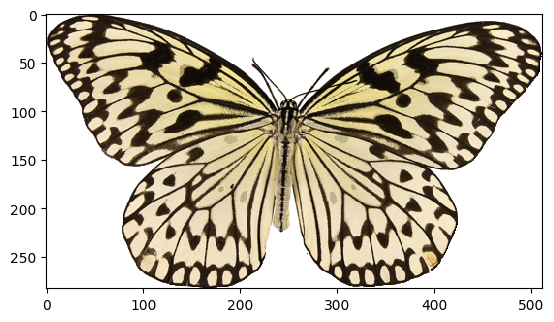

In [38]:
example = dataset[0]["image"]
example_t_0 = np.array(example)/255
print(example_t_0.shape)
plt.imshow(example_t_0, interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


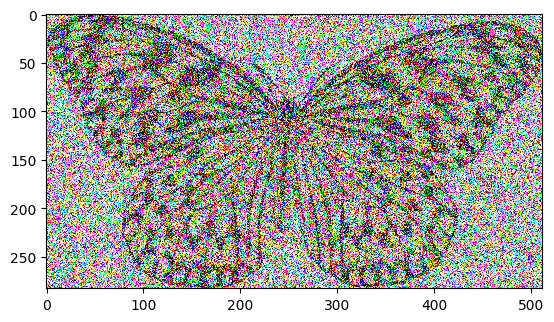

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


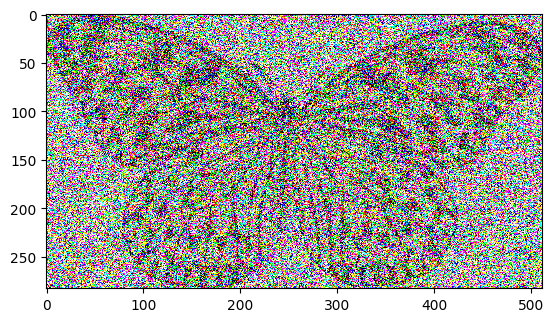

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


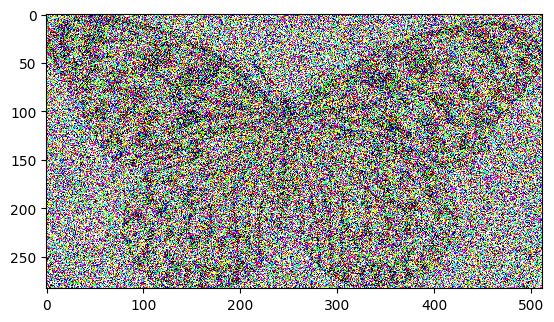

In [51]:
mean = 0 
std = 1
noise_array = np.random.normal(loc = mean , scale = std, size = example_t_0.shape)
example_t_1 = example_t_0 + noise_array
plt.imshow(example_t_1, interpolation='nearest')
plt.show()

noise_array = np.random.normal(loc = mean , scale = std, size = example_t_1.shape)
example_t_2 = example_t_1 + noise_array
plt.imshow(example_t_2, interpolation='nearest')
plt.show()


noise_array = np.random.normal(loc = mean , scale = std, size = example_t_2.shape)
example_t_3 = example_t_2 + noise_array
plt.imshow(example_t_3, interpolation='nearest')
plt.show()


### Diffusion Model

In [3]:
# !pip install 'diffusers[training]'

In [34]:
# !huggingface-cli login

In [36]:
#!sudo apt -qq install git-lfs
#!git config --global credential.helper store

In [37]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub
    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "bruno-moreno/butterfly-diffusion-model"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [7]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")
dataset 

/Users/bmoreno/miniforge3/envs/data-science/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/bmoreno/miniforge3/envs/data-science/lib/python3.9/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

/var/folders/hz/f5b_t7pn021_8wg59m0mm2lw0000gn/T/ipykernel_2162/3278871621.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


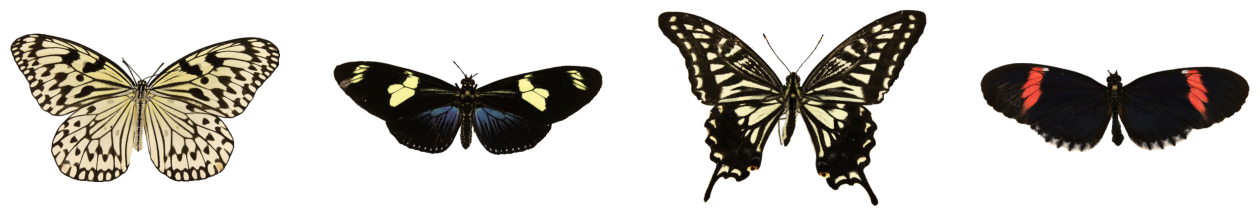

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [11]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [12]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [23]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [16]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [18]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


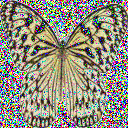

In [19]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [22]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [24]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [25]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [26]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [40]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on MPS.


/Users/bmoreno/miniforge3/envs/data-science/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


RuntimeError: User specified an unsupported autocast device_type 'mps'

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])